In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [4]:
def process_ios(df, writes=True):
    PAGESIZE = 4096
    if writes:
        nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
        robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
        workload_weight = df['w_s'] / df['w_s'].sum()
        df['nominal_write_io'] = (workload_weight * nominal_compaction_ios) + ((df['nominal_bytes_written'] + df['nominal_flush_written']) / PAGESIZE)
        df['robust_write_io'] = (workload_weight * robust_compaction_ios) + ((df['robust_bytes_written'] + df['robust_flush_written']) / PAGESIZE)
        df['nominal_io'] = df['nominal_blocks_read'] + df['nominal_write_io']
        df['robust_io'] = df['robust_blocks_read'] +  df['robust_write_io']
    else:
        df['nominal_io'] = df['nominal_blocks_read']
        df['robust_io'] = df['robust_blocks_read']
    
    return df

In [12]:
def plot_total_io_diff(df, workload_idx, normalize=False, mode='io', writes=True):
    df = df[df.workload_idx == workload_idx]
    z0, z1, q, w = df.z0.iloc[0], df.z1.iloc[0], df.q.iloc[0], df.w.iloc[0]
    ops = df.groupby('N')['num_queries'].sum().values if normalize else 1
    df = df.groupby('N').apply(process_ios, writes=writes)
    if mode == 'io':
        df = df.groupby('N')[['robust_io', 'nominal_io']].sum().reset_index()
        y1, y2 = df['robust_io'], df['nominal_io']
    else:
        df = df.groupby('N')[['robust_ms', 'nominal_ms']].sum().reset_index()
        y1, y2 = df['robust_ms'], df['nominal_ms']
        
    y1, y2 = y1 / ops, y2 / ops
        
    fig, ax = plt.subplots()
    
    ax.plot(df['N'], y1, marker='*', color='green', label='Robust')
    ax.plot(df['N'], y2, marker='o', color='black', label='Nominal')
    ax.set_xscale('log')
    ax.set_ylabel(f'{"Average" if normalize else "Total"} {"I/O" if mode == "io" else "Response (ms)"} per Query')
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Number of Elements in DB (N)')
    ax.set_title(
        f'Performance Difference with Database Size {"(Read Only)" if not(writes) else ""}' + '\n'
        '$w_{' + str(workload_idx) + '}$ : ' + f'({z0:.0%}, {z1:.0%}, {q:.0%}, {w:.0%})' 
    )
    ax.legend()
    
    return fig, ax

Possible workloads : [ 7 11 16]


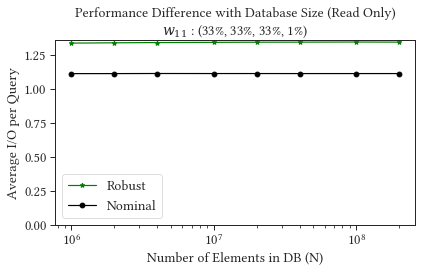

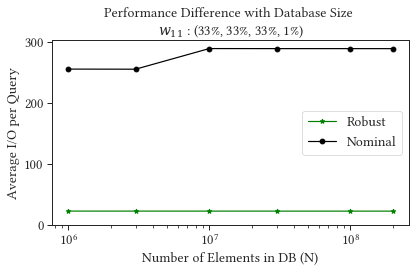

In [95]:
df = dp.read_csv('exp_05_no_writes_unique.csv')
# df = dp.read_csv('exp_05_pt02.csv')
# df = dp.read_csv('exp_05_writes.csv')
df['nominal_ms'] = df['nominal_z0_ms'] + df['nominal_z1_ms'] + df['nominal_q_ms'] + df['nominal_w_ms']
df['robust_ms'] = df['robust_z0_ms'] + df['robust_z1_ms'] + df['robust_q_ms'] + df['robust_w_ms']
print(f'Possible workloads : {df.workload_idx.unique()}')
wl_idx, normalize, mode, writes = 11, True, 'io', False

set_style()
fig, ax = plot_total_io_diff(df, wl_idx, normalize, mode, writes)
set_size(fig)

df = dp.read_csv('exp_05_writes.csv')
wl_idx, normalize, mode, writes = 11, True, 'io', True
set_style()
fig, ax = plot_total_io_diff(df, wl_idx, normalize, mode, writes)
set_size(fig)
# fig, ax = plot_total_io_diff(df, 7, normalize, mode, writes)
# set_size(fig)
# fig, ax = plot_total_io_diff(df, 11, normalize, mode, writes)
# set_size(fig)
# fig, ax = plot_total_io_diff(df, 16, normalize, mode, writes)
# set_size(fig)

In [80]:
tunings = ['num_queries', 'nominal_m_buff', 'nominal_bpe', 
           'nominal_T', 'nominal_is_leveling_policy',
           'nominal_runs_per_level',
           'robust_m_buff', 'robust_bpe',
           'robust_T', 'robust_is_leveling_policy',
           'robust_runs_per_level']
a = df[df.workload_idx == wl_idx].groupby('N')[tunings].first()
a['robust_m_buff'] = a['robust_m_buff'] / 8 / 1024 / 1024
a['nominal_m_buff'] = a['nominal_m_buff'] / 8 / 1024 / 1024
a

,num_queries,nominal_m_buff,nominal_bpe,nominal_T,nominal_is_leveling_policy,nominal_runs_per_level,robust_m_buff,robust_bpe,robust_T,robust_is_leveling_policy,robust_runs_per_level
N,,,,,,,,,,,
1000000.0,1000.0,1.000000,10.000000,9.588153,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.555518,5.339973,2.384649,True,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3000000.0,3000.0,1.334442,9.064832,9.068589,False,"[0, 3, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3.001836,4.402462,2.416440,True,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10000000.0,10000.0,3.145386,8.200319,8.394138,False,"[0, 5, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",8.184506,3.973199,2.435883,True,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
30000000.0,30000.0,8.450715,7.916629,8.134933,False,"[0, 5, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",23.048308,3.834846,2.443799,True,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
100000000.0,100000.0,27.064001,7.813593,8.041415,False,"[0, 5, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",75.051152,3.788139,2.445702,True,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
200000000.0,200000.0,53.647231,7.791815,8.022013,False,"[0, 5, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",149.356894,3.777461,2.446278,True,"[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [294]:
def plot_total_io_diff_pair(df1, df2, workload_idx, normalize=False, mode='io'):
    z0, z1, q, w = df1.z0.iloc[0], df1.z1.iloc[0], df1.q.iloc[0], df1.w.iloc[0]
    z01, z11, q1, w1 = df1[df1['N'] == 1e7][['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    z02, z12, q2, w2 = df2[df2['N'] == 1e7][['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    ops1 = df1.groupby('N')['num_queries'].sum().values if normalize else 1
    ops2 = df2.groupby('N')['num_queries'].sum().values if normalize else 1
    df1 = df1.groupby('N').apply(process_ios, writes=False)
    df2 = df2.groupby('N').apply(process_ios, writes=True)
    if mode == 'io':
        df1 = df1.groupby('N')[['robust_io', 'nominal_io']].sum().reset_index()
        y11, y21 = df1['robust_io'] / ops1, df1['nominal_io'] / ops1
        df2 = df2.groupby('N')[['robust_io', 'nominal_io']].sum().reset_index()
        y12, y22 = df2['robust_io'] / ops2, df2['nominal_io'] / ops2
    else:
        df1 = df1.groupby('N')[['robust_ms', 'nominal_ms']].sum().reset_index()
        y11, y21 = df1['robust_ms'], df1['nominal_ms']
        df2 = df2.groupby('N')[['robust_ms', 'nominal_ms']].sum().reset_index()
        y12, y22 = df2['robust_ms'], df2['nominal_ms']
        
    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout=True, constrained_layout=False)
    ax1, ax2 = axes
    
    ax1.plot(df1['N'], y11, marker='*', color='green', label='Robust')
    ax1.plot(df1['N'], y21, marker='o', color='black', label='Nominal')
    ax1.set_xscale('log')
    ax1.set_ylim(bottom=0, top=1.4)
    ax1.set_title('$\hat{w}$ : ' + f'({z01:.0%}, {z11:.0%}, {q1:.0%}, {w1:.0%})')
    ax1.legend(frameon=True, framealpha=1, edgecolor='black', fancybox=False)
    
    ax2.plot(df2['N'], y12, marker='*', color='green', label='Robust')
    ax2.plot(df2['N'], y22, marker='o', color='black', label='Nominal')
    ax2.set_xscale('log')
    ax2.set_ylim(bottom=0)
    ax2.set_title('$\hat{w}$ : ' + f'({z02:.0%}, {z12:.0%}, {q2:.0%}, {w2:.0%})')
    
    fig.suptitle(
                 'Expected Workload : $w_{' + str(workload_idx) + '}$ : ' + f'({z0:.0%}, {z1:.0%}, {q:.0%}, {w:.0%})',
                 y=0.9, x=0.55)
    fig.supylabel(f'{"Average" if normalize else "Total"} {"I/Os" if mode == "io" else "Response (ms)"} per Query',
                  x=0.05)
    fig.supxlabel('Number of Elements in DB (N)', y=0.08)
    
    return fig, axes

Possible workloads : [ 7 11 16]


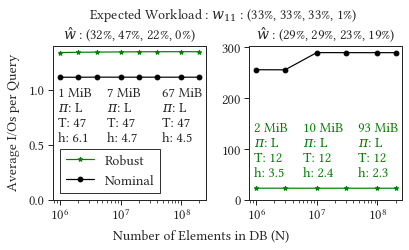

In [297]:
df1 = dp.read_csv('exp_05_no_writes_unique.csv')
df2 = dp.read_csv('exp_05_writes.csv')
print(f'Possible workloads : {df.workload_idx.unique()}')
wl_idx, normalize, mode, writes = 11, True, 'io', False
df1 = df1[df1['workload_idx'] == wl_idx].reset_index()
df2 = df2[df2['workload_idx'] == wl_idx].reset_index()

nom_labels = []
for n in [1e6, 1e7, 1e8]:
    buff = df1[df1["N"] == n]["nominal_m_buff"].iloc[0] / (1024 * 1024 * 8)
    T = df1[df1["N"] == n]["nominal_T"].iloc[0]
    bpe = df1[df1["N"] == n]["nominal_bpe"].iloc[0]
    policy = 'L' if df1[df1["N"] == n]["nominal_is_leveling_policy"].iloc[0] else 'T'
    nom_labels.append(f"{buff:.0f} MiB\n$\pi$: {policy}\nT: {T:.0f}\nh: {bpe:.1f}") 
    
robust_labels = []
for n in [1e6, 1e7, 1e8]:
    buff = df1[df1["N"] == n]["robust_m_buff"].iloc[0] / (1024 * 1024 * 8)
    T = df1[df1["N"] == n]["robust_T"].iloc[0]
    bpe = df1[df1["N"] == n]["robust_bpe"].iloc[0]
    policy = 'L' if df1[df1["N"] == n]["robust_is_leveling_policy"].iloc[0] else 'T'
    robust_labels.append(f"{buff:.0f} MiB\n$\pi$: {policy}\nT: {T:.0f}\nh: {bpe:.1f}") 
    
set_style()
fig, axes = plot_total_io_diff_pair(df1, df2, wl_idx, normalize, mode)
axes[0].text(0.03, 0.38, nom_labels[0], transform=axes[0].transAxes)
axes[0].text(0.35, 0.38, nom_labels[1], transform=axes[0].transAxes)
axes[0].text(0.71, 0.38, nom_labels[2], transform=axes[0].transAxes)
axes[1].text(0.03, 0.15, robust_labels[0], transform=axes[1].transAxes, color='green')
axes[1].text(0.35, 0.15, robust_labels[1], transform=axes[1].transAxes, color='green')
axes[1].text(0.71, 0.15, robust_labels[2], transform=axes[1].transAxes, color='green')

set_size(fig)
save_fig(fig, 'perf_db_size.pdf')

In [267]:
df2[df2['N'] == 1e7]

,index,workload_idx,z0,z1,q,w,N,phi,B,s,E,M,nominal_m_filt,nominal_m_buff,nominal_T,nominal_cost,nominal_bpe,nominal_is_leveling_policy,rho,robust_exit_mode,robust_m_filt,robust_m_buff,robust_T,robust_cost,robust_is_leveling_policy,robust_bpe,sample_idx,num_queries,z0_s,z1_s,q_s,w_s,kl_div,session_id,nominal_l0_hit,nominal_l1_hit,nominal_l2_plus_hit,nominal_z0_ms,nominal_z1_ms,nominal_q_ms,nominal_w_ms,nominal_filter_neg,nominal_filter_pos,nominal_filter_pos_true,nominal_bytes_written,nominal_compact_read,nominal_compact_write,nominal_flush_written,nominal_blocks_read,nominal_runs_per_level,robust_l0_hit,robust_l1_hit,robust_l2_plus_hit,robust_z0_ms,robust_z1_ms,robust_q_ms,robust_w_ms,robust_filter_neg,robust_filter_pos,robust_filter_pos_true,robust_bytes_written,robust_compact_read,robust_compact_write,robust_flush_written,robust_blocks_read,robust_runs_per_level
60,240,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.466287,True,2.417723,3193.0,10000.0,0.4604,0.4317,0.0000,0.1079,0.525939,0.0,197,4220,0,15,373,0,20465,13207,4438,4417,1122160,10413432607,10412478976,1127517,4443,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",130,345,3942,31,381,0,1730,21551,4607,4417,1122160,864848340,863545856,1127005,4623,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
61,241,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.466287,True,2.417723,8043.0,10000.0,0.5864,0.2222,0.1667,0.0247,0.157739,0.0,0,2222,0,8,194,288,5,5842,2244,2222,256880,0,0,259165,5581,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,147,2075,26,193,453,5,13572,2453,2222,256880,0,0,259165,7487,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
62,242,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.466287,True,2.417723,8326.0,10000.0,0.4737,0.3626,0.1520,0.0117,0.089398,0.0,0,3626,0,7,317,427,19813,13029,3648,3626,121680,10414450689,10412858880,123486,8211,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,271,3355,23,316,591,1739,20959,3810,3626,121680,864721782,863925248,123486,9889,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
63,243,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.466287,True,2.417723,5692.0,10000.0,0.3712,0.5000,0.0000,0.1288,0.580600,0.0,0,5000,0,5,440,0,12,3693,5019,5000,1339520,0,0,1345630,5021,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,391,4609,17,439,0,12,11889,5144,5000,1339520,0,0,1345118,5162,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
64,244,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.466287,True,2.417723,5539.0,10000.0,0.3060,0.5410,0.0656,0.0874,0.327823,0.0,1,5409,0,4,478,218,19840,11509,5425,5410,908960,10416350824,10415112704,913502,7392,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1,435,4974,15,468,269,1670,19425,5543,5410,908960,866617656,866177536,912990,8177,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
65,245,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.466287,True,2.417723,8523.0,10000.0,0.0941,0.0706,0.8118,0.0235,0.523890,1.0,0,706,0,4,83,1540,8,939,708,706,244400,0,0,246878,16944,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,52,654,5,61,2206,5,2497,745,706,244400,0,0,246878,25198,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
66,246,11,0.33,0.33,0.33,0.01,10000000.0,1,4,0.0,8192,108388608.0,4.668040e+07,6.170821e+07,46.997058,1.200135,4.66804,True,0.25,0,2.417723e+07,8.421138e+07,11.854252,1.46